In [1]:
%matplotlib inline

N = 640
1
1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


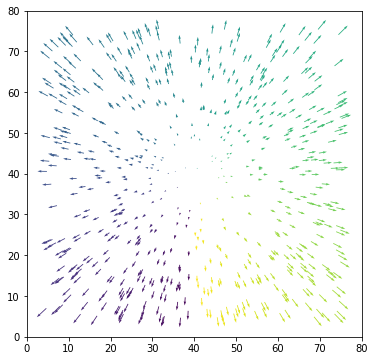

In [3]:
# -*- coding: utf-8 -*-
"""
@author: Daniel

Note: make sure latest version of scipy is installed
"""
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
 
L = 80.0 # size of domain
rho = 0.1 # density of particles
N = int(rho*L**2) # number of particles
print("N =",N)
 
deltat = 1.0 # time step
vmax = 4/15 # max particle speed
vmax_comp = vmax/2**0.5 # max particle speed in a given component
iterations = 250 # number of time steps

def get_v(p): # function describing v as a functioning of initial position
    return (p-L/2)/(L/2)*vmax

all_pos = np.zeros(shape=(N,2,iterations))
all_v = np.zeros(shape=(N,2, iterations))
pos = np.random.uniform(L/3,2*L/3,size=(N,2)) # positions of particles
#v = np.random.uniform(-vmax_comp, vmax_comp, size=(N,2)) # orientations of particles
v = np.zeros(shape=(N,2))
for i in range(N):
    v[i, :] = get_v(pos[i, :])

fig, ax= plt.subplots(figsize=(6,6))
 
qv = ax.quiver(pos[:,0], pos[:,1], v[:,0], v[:, 1], np.arctan2(v[:,0], v[:,1]), clim=[-np.pi, np.pi])
ax.axis([0, L, 0, L])
 
def animate(i):
    print(i)
    global pos
    
    pos += deltat*v
    # periodic boundary conditions
    pos[pos>L] -= L
    pos[pos<0] += L
    
    all_pos[:, :, i-1] = pos
    all_v[:, :, i-1] = v
 
    qv.set_offsets(pos)
    qv.set_UVC(v[:,0], v[:, 1], np.arctan2(v[:,0], v[:,1]))
    return qv,
 
anim = FuncAnimation(fig, animate, np.arange(1, iterations), interval=1, blit=True)
anim.save('burgers.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [4]:
def save(filename, *args):
    with open(filename, 'wb') as f:
        for arr in args:
            np.save(f, arr)
            
def load(filename, nload):
    to_load = []
    with open(filename, 'rb') as f:
        for i in range(nload):
            to_load.append(np.load(f))
    return tuple(to_load)
    
save('data_bu.npy', all_pos, all_v)

In [5]:
# coarse-graining
res = 4 # number of points per unit length of L
width = int(res*L) # length of domain in grid points

# binned density 
binned_pts = np.zeros(shape=(width, width, iterations))
# binned rho*velocity
binned_rv = np.zeros(shape=(width, width, iterations, 2))
# binned velocity (not actually used, for illustration only)
binned_v = np.zeros(shape=(width, width, iterations, 2))

for i in range(iterations):
    for j in range(N):
        pt = all_pos[j, :, i]*res
        binned_pts[int(pt[0]), int(pt[1]), i] += 1
        binned_rv[int(pt[0]), int(pt[1]), i, :] += all_v[j, :, i]
binned_pts *= res**2
binned_rv *= res**2
for x in range(width):
    for y in range(width):
        for z in range(iterations):
            if binned_pts[x, y, z]>0:
                binned_v[x, y, z, :] = binned_rv[x, y, z, :]/binned_pts[x, y, z]

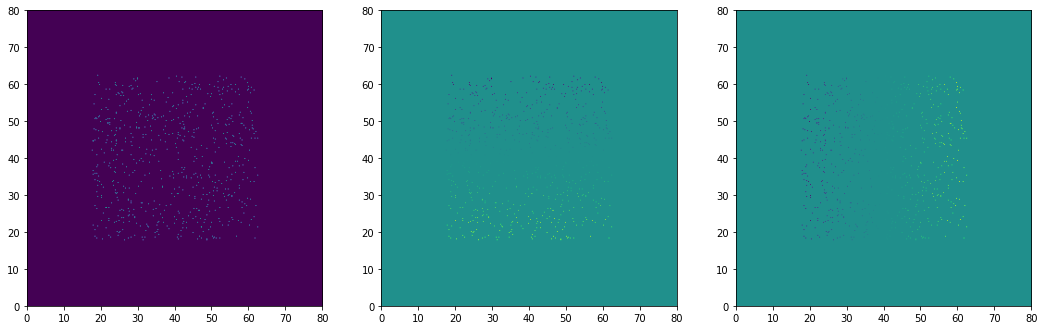

In [6]:
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, figsize=(18,6))
ax1.imshow(binned_pts[:, :, 100], extent=[0, L, 0, L])
ax2.imshow(binned_v[:, :, 100, 0], extent=[0, L, 0, L])
ax3.imshow(binned_v[:, :, 100, 1], extent=[0, L, 0, L])

In [7]:
from scipy.ndimage import gaussian_filter

def coarse_grain(binned, positions=None):
    # positions - optional argument for tuning width of kernel and such
    sigma = res # width of convolution kernel
    sigma_vector = np.zeros(shape=(len(binned.shape),1))
    sigma_vector[0:2] = sigma
    smoothed = gaussian_filter(binned, sigma_vector, mode='wrap', truncate=12)
    return smoothed

rho = coarse_grain(binned_pts)
rv = coarse_grain(binned_rv)
v = np.copy(rv)

nzind = rho[:]>0
zind = rho[:]==0
v[nzind, 0] = rv[nzind, 0]/rho[nzind]
v[zind, 0] = 0
v[nzind, 1] = rv[nzind, 1]/rho[nzind]
v[zind, 1] = 0

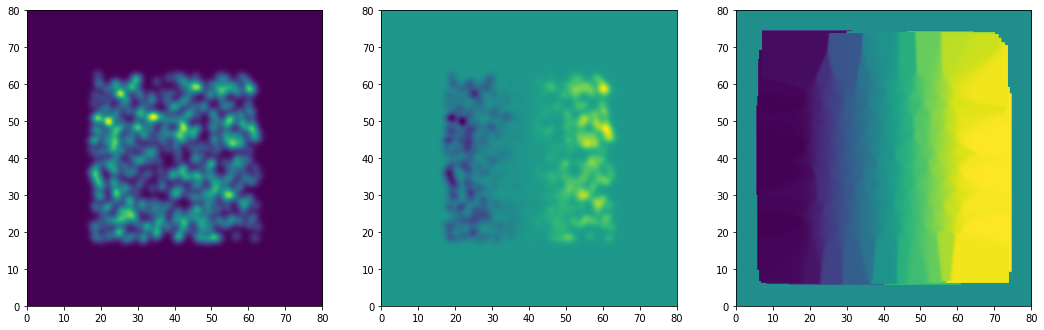

In [8]:
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, figsize=(18,6))
ax1.imshow(rho[:, :, 100], extent=[0, L, 0, L])
ax2.imshow(rv[:, :, 100, 1], extent=[0, L, 0, L])
ax3.imshow(v[:, :, 100, 1], extent=[0, L, 0, L])

In [11]:
save('arrays_bu_rv.npy', rho, rv, res, deltat)

In [12]:
c, d, e, f = load('arrays_bu_rv.npy', 4)
c.shape, d.shape, e, f

((320, 320, 250), (320, 320, 250, 2), array(4), array(1.))

In [29]:
np.min(binned_v[:, ...]), np.min(all_v[:, ...]), np.mean(rho[:, ...]), 0.1

(-0.08880484028088882, -0.08880484028088882, 0.10000000000000016, 0.1)